### Script to convert streampix Norpix file into a folder of .npy/.mat files

To read file in binary way, use:
file.seek(starting position in bytes)
read_bytes = file.read(numbytes) to read in certain amount of bytes
struct.unpack('format',read_bytes) to intepret byte format into its own format
Output of 150x150 = 22500 frames takes 4000 seconds

In [2]:
import struct
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import time
import scipy.signal

#### Load in dark and gain ref image
MRC file generated by streampix is too old to be loaded using python mrcfile package, has to open as binary file and load data. Inside the MRC file, data is saved from byte #256, row-wisely. Result is the transposed version of Matlab MRC reader, so no need to transpose again.

(-0.5, 511.5, 511.5, -0.5)

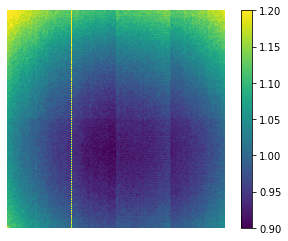

In [6]:
# temp = loadMRCfile('/srv/home/chenyu/DEbackup/051519/Diffraction_rotation/S0.seq.dark.mrc')
# plt.imshow(temp)
# plt.colorbar()
# plt.axis('off')

# lineprofile = np.average(temp,axis=1)
# # lineprofile[100:-100].resize(200)
# plt.plot(lineprofile[100:-100])

temp = loadMRCfile('D:/2020/TitanCalibration/062520_Calibration/BeamCurrent/DE16.seq.gain.mrc')
plt.imshow(temp)
plt.clim([0.9,1.2])
plt.colorbar()
plt.axis('off')

In [3]:
def loadMRCfile(filepath):
    with open(filepath, mode='rb') as file: # b is important -> binary
        file.seek(0)
        read_bytes = file.read(8)
        frame_width = struct.unpack('<i',read_bytes[0:4])
        frame_width = frame_width[0]
        frame_height = struct.unpack('<i',read_bytes[4:8])
        frame_height = frame_height[0]
        image = np.zeros((frame_height,frame_width))
        file.seek(256*4)
        dataset = file.read(frame_width*frame_height*4)
        for irow in range(frame_height):
            for icol in range(frame_width):
                pixel = struct.unpack('<f',dataset[(irow*frame_width+icol)*4:(irow*frame_width+icol+1)*4])[0]
                image[irow,icol] = pixel
        return image

#### Load norpix file headers properties and print

In [7]:
def loadHeader(fileName,darkref):
    print('Reading file ' + fileName)
    with open(fileName, mode='rb') as file: # b is important -> binary
        file.seek(548)
        read_bytes = file.read(20)
        frame_width = struct.unpack('<L',read_bytes[0:4])
        frame_height = struct.unpack('<L',read_bytes[4:8])
        bit_depth = struct.unpack('<L',read_bytes[8:12])
        bit_depth_real = struct.unpack('<L',read_bytes[12:16])
        frame_bytesize = struct.unpack('<L',read_bytes[16:20])
        print('Each frame is ' + str(frame_width[0]) + ' by ' + str(frame_height[0]) + ' px.')

        file.seek(572)
        read_bytes = file.read(4)
        num_frames = struct.unpack('<i',read_bytes)
        print('Total ' + str(num_frames[0]) + ' frames collected.')

        file.seek(584)
        read_bytes = file.read(8)
        frame_rate = struct.unpack('<d',read_bytes)
        print('Image acquired at ' + str(frame_rate[0]) + ' frames per second.')

        file.seek(580)
        read_bytes = file.read(4)
        true_imagesize = struct.unpack('<L',read_bytes[0:4])

        if frame_width[0] != darkref.shape[0] or frame_height[0] != darkref.shape[1]:
            print('Norpix frame size (' + str(frame_height[0]) + ',' +str(frame_width[0]) +  ') disagree with reference size' + str(darkref.shape))
            
        return num_frames[0],true_imagesize[0]

#### Load each frame then save to mat/npy file
Matlab version further round intensity on each pixel to 16bit integer, which is not applied in this version

In [8]:
def saveFile(fileName, savebaseName, savingPath, darkref, gainref, numframes, true_imagesize):
    with open(fileName, mode='rb') as file:
        savename = savebaseName + '_PACBED.npy'
        frame = np.zeros((darkref.shape[0],darkref.shape[1]))
        for iframe in range(numframes):
            file.seek(8192 + iframe * true_imagesize)
            read_bytes = file.read(darkref.shape[0] * darkref.shape[1] * 2)
            frame_raw = np.reshape(np.frombuffer(read_bytes,dtype=np.uint16),darkref.shape)
#             frame_raw = np.zeros((darkref.shape[0],darkref.shape[1]))
#             for irow in range(darkref.shape[0]):
#                 for icol in range(darkref.shape[1]):
#                     pixel = struct.unpack('<h',read_bytes[(irow*darkref.shape[1]+icol)*2:(irow*darkref.shape[1]+icol+1)*2])[0]
#                     frame_raw[irow,icol] = pixel
            frame = frame + (frame_raw - darkref)*gainref
        frame = frame / numframes
        np.save(savingPath + savename, frame)

### Main method to run everything

In [9]:
def main(fileName, darkrefFile, gainrefFile, savingPath, savebaseName):

    start = time.time()
    darkref = loadMRCfile(darkrefFile)
    gainref = loadMRCfile(gainrefFile)
    if darkref.shape != gainref.shape:
        print('Dark and gain reference shape disagree!')
    else:
        fig=plt.figure(figsize=(12, 6))
        columns = 2
        rows = 1
        fig.add_subplot(rows, columns, 1)
        plt.imshow(darkref)
        plt.title('Dark reference')
        #plt.colorbar()
        fig.add_subplot(rows, columns, 2)
        plt.imshow(gainref)
        plt.title('Gain reference')
        #plt.colorbar()
        plt.show()

    numframes, true_imagesize = loadHeader(fileName,darkref)
    saveFile(fileName, savebaseName, savingPath, darkref, gainref, numframes, true_imagesize)
    end = time.time()
    print('Total time elapsed: ' + str(end-start))

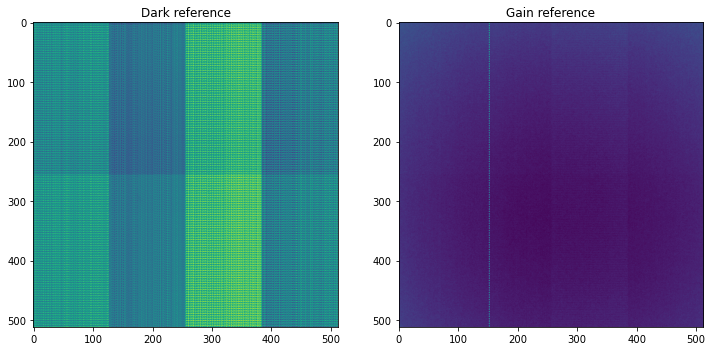

Reading file D:/2020/TitanCalibration/062520_Calibration/BeamCurrent/DE16.seq
Each frame is 512 by 512 px.
Total 10312 frames collected.
Image acquired at 1100.2987622705932 frames per second.
Total time elapsed: 81.28177070617676


In [11]:
if __name__ == '__main__':
    fileName = 'D:/2020/TitanCalibration/062520_Calibration/BeamCurrent/DE16.seq'
    darkrefFile = 'D:/2020/TitanCalibration/062520_Calibration/BeamCurrent/DE16.seq.dark.mrc'
    gainrefFile = 'D:/2020/TitanCalibration/062520_Calibration/BeamCurrent/DE16.seq.gain.mrc'
    savingPath = 'D:/2020/TitanCalibration/062520_Calibration/BeamCurrent/npy/'
    savebaseName = 'S0'
    main(fileName, darkrefFile, gainrefFile, savingPath, savebaseName)

#### Sanity check: compare Python version Norpix2Npy to Matlab version Norpix2matlab
Compared Python generated file and Matlab generated file elementwisely and confirmed that they are the same, Matlab version round each pixel using uint16, which would force all negative values to be zero. This option is not applied in Python version.

In [131]:
fileName = '/srv/home/chenyu/DEbackup/081018/BGtest/1000FPS_512x512.seq'
darkrefFile = '/srv/home/chenyu/DEbackup/081018/BGtest/1000FPS_512x512.seq.dark.mrc'
gainrefFile = '/srv/home/chenyu/DEbackup/081018/BGtest/1000FPS_512x512.seq.gain.mrc'
savingPath = '/srv/home/chenyu/DEbackup/081018/BGtest/1000FPS_512x512_center_np/'
savebaseName = '1000FPS_512x512'

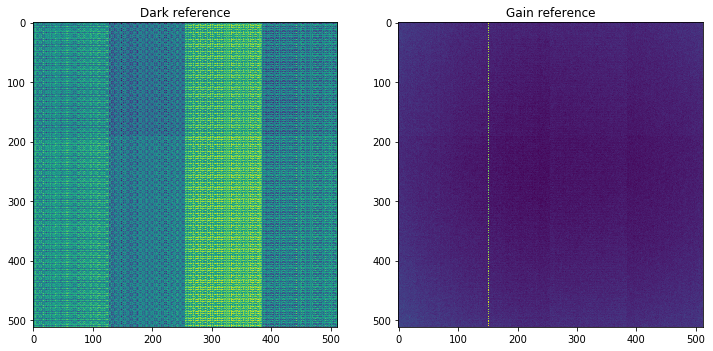

In [132]:
darkref = loadMRCfile(darkrefFile)
gainref = loadMRCfile(gainrefFile)
if darkref.shape != gainref.shape:
    print('Dark and gain reference shape disagree!')
else:
    fig=plt.figure(figsize=(12, 6))
    columns = 2
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(darkref)
    plt.title('Dark reference')
    #plt.colorbar()
    fig.add_subplot(rows, columns, 2)
    plt.imshow(gainref)
    plt.title('Gain reference')
    #plt.colorbar()
    plt.show()

In [10]:
fileName = 'D:/2020/TitanCalibration/062520_Calibration/BeamCurrent/DE16.seq'
darkrefFile = 'D:/2020/TitanCalibration/062520_Calibration/BeamCurrent/DE16.seq.dark.mrc'
gainrefFile = 'D:/2020/TitanCalibration/062520_Calibration/BeamCurrent/DE16.seq.gain.mrc'
savingPath = 'D:/2020/TitanCalibration/062520_Calibration/BeamCurrent/npy/'
savebaseName = 'S0'
darkref = loadMRCfile(darkrefFile)
gainref = loadMRCfile(gainrefFile)
numframes, true_imagesize = loadHeader(fileName,darkref)
print(true_imagesize)
print(numframes)
# saveFile(fileName, savebaseName, savingPath, darkref, gainref)
saveFile(fileName, savebaseName, savingPath, darkref, gainref, numframes, true_imagesize)

Reading file D:/2020/TitanCalibration/062520_Calibration/BeamCurrent/DE16.seq
Each frame is 512 by 512 px.
Total 10312 frames collected.
Image acquired at 1100.2987622705932 frames per second.
532480
10312


Use 10th frame for example, cast each frame to integer then force all negative values to zero, show exact same result as Matlab version

In [160]:
reference_frame = scipy.io.loadmat('/srv/home/chenyu/DEbackup/081018/BGtest/1000FPS_512x512_center/1000FPS_512x512_00010.mat')
reference_frame = reference_frame['UYVYimg']
frame = np.load('/srv/home/chenyu/DEbackup/081018/BGtest/1000FPS_512x512_center_np/1000FPS_512x512_00010.npy')
frame = np.rint(frame)
frame = (frame + abs(frame))/2
diff = frame - reference_frame

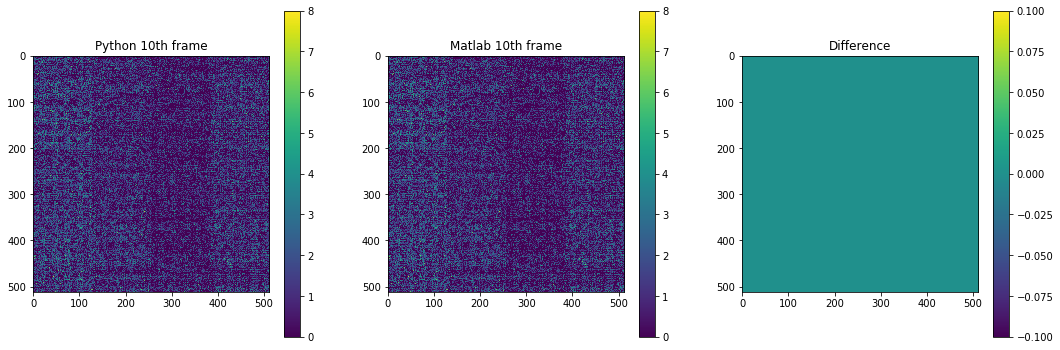

In [161]:
fig=plt.figure(figsize=(18, 6))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(frame)
plt.title('Python 10th frame')
plt.colorbar()
fig.add_subplot(rows, columns, 2)
plt.imshow(reference_frame)
plt.title('Matlab 10th frame')
plt.colorbar()
fig.add_subplot(rows, columns, 3)
plt.imshow(diff)
plt.title('Difference')
plt.colorbar()
plt.show()